In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import os
import shutil

# Download and extract the flower dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

# Create a smaller dataset for quick training
small_data_dir = "small_flower_photos"
os.makedirs(small_data_dir, exist_ok=True)

# Copy a few images from each class to the smaller dataset
for flower_class in ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']:
    class_dir = os.path.join(data_dir, flower_class)
    small_class_dir = os.path.join(small_data_dir, flower_class)
    os.makedirs(small_class_dir, exist_ok=True)
    images = os.listdir(class_dir)[:10]  # Limit to 10 images per class
    for img in images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(small_class_dir, img))

# Load the small dataset
batch_size = 4
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    small_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    small_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalize pixel values
normalization_layer = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 50 files belonging to 5 classes.
Using 40 files for training.
Found 50 files belonging to 5 classes.
Using 10 files for validation.


In [3]:
# Load VGG16 pre-trained model
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 flower classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.2295 - loss: 1.8108 - val_accuracy: 0.5000 - val_loss: 1.4971
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.3143 - loss: 1.7146 - val_accuracy: 0.6000 - val_loss: 1.4659
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.3890 - loss: 1.4828 - val_accuracy: 0.6000 - val_loss: 1.5157
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3387 - loss: 1.5256 - val_accuracy: 0.6000 - val_loss: 1.4079
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5581 - loss: 1.3085 - val_accuracy: 0.9000 - val_loss: 1.2751


In [5]:
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:10]:  # Keep the first 10 layers frozen
    layer.trainable = False

# Compile and fine-tune
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=3)


Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.5636 - loss: 1.1800 - val_accuracy: 0.7000 - val_loss: 1.1802
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.6567 - loss: 1.0108 - val_accuracy: 0.8000 - val_loss: 1.0146
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.6691 - loss: 0.8589 - val_accuracy: 0.8000 - val_loss: 0.9001


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


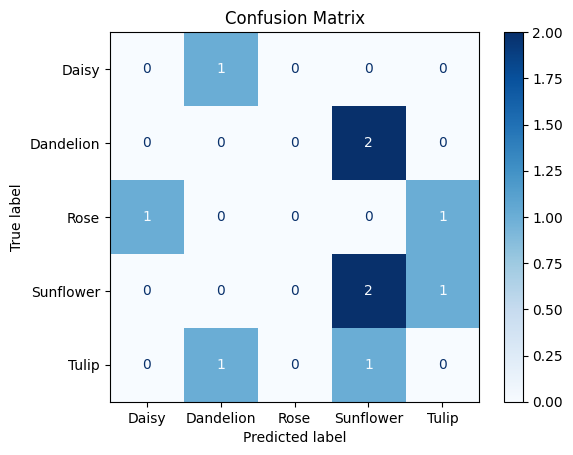

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions and true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=-1)

# Create and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


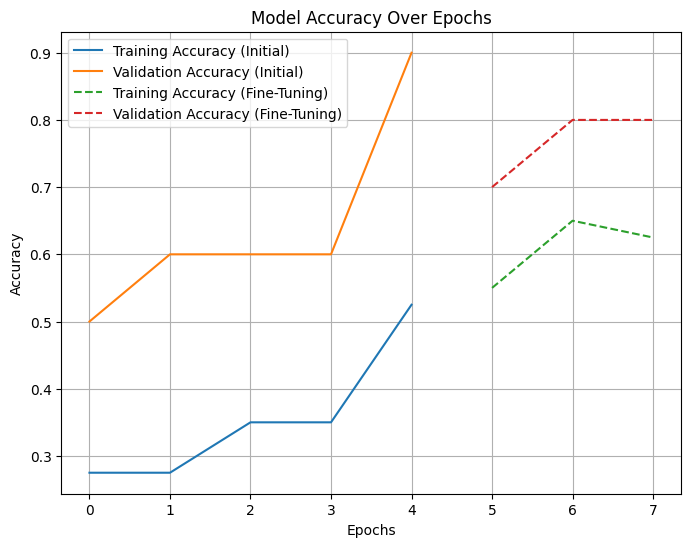

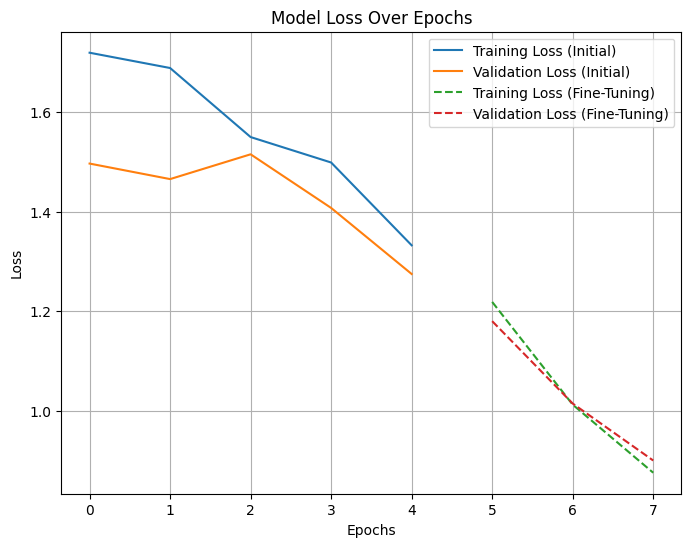

In [7]:
# Training history
history_data = {
    "accuracy": history.history['accuracy'],
    "val_accuracy": history.history['val_accuracy'],
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss']
}

fine_tune_history_data = {
    "accuracy": fine_tune_history.history['accuracy'],
    "val_accuracy": fine_tune_history.history['val_accuracy'],
    "loss": fine_tune_history.history['loss'],
    "val_loss": fine_tune_history.history['val_loss']
}

# Plot accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(range(5, 8), fine_tune_history_data['accuracy'], label='Training Accuracy (Fine-Tuning)', linestyle='--')
plt.plot(range(5, 8), fine_tune_history_data['val_accuracy'], label='Validation Accuracy (Fine-Tuning)', linestyle='--')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss (Initial)')
plt.plot(history_data['val_loss'], label='Validation Loss (Initial)')
plt.plot(range(5, 8), fine_tune_history_data['loss'], label='Training Loss (Fine-Tuning)', linestyle='--')
plt.plot(range(5, 8), fine_tune_history_data['val_loss'], label='Validation Loss (Fine-Tuning)', linestyle='--')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
